In [1]:
import os
import seaborn as sns
path = '/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Analysis/Figures'
import sys
sys.path.insert(1, '/Users/connormcdonald/Desktop/Masters/MIT807/Gartner Repository/Data Collection')
from configs import *
import numpy as np
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# from mpl_toolkits.axisartist.axislines import SubplotZero
# from pylab import text
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "lualatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

from sqlalchemy import create_engine

engine = create_engine('mysql+mysqlconnector://'+user+':'+passwd+'@'+ip+':3306/'+schema1)

In [10]:
stmt = ''' SELECT 
A.date,
COUNT(1) as num_tweets,
AVG(B.mnb_prediction) AS mnb,
AVG(B.svm_prediction) AS svm,
AVG(B.lr_prediction) AS lr,
AVG(B.ensemble_prediction) AS ens
FROM social.machine_learning_only A
INNER JOIN social.ML_sentiment B 
ON A.id = B.id
WHERE A.date>='2013-05-01' AND A.date<='2013-06-30' 
GROUP BY A.date 
ORDER BY A.date ASC'''

df = pd.read_sql(stmt, con=engine)
df['date'] = pd.to_datetime(df['date'])

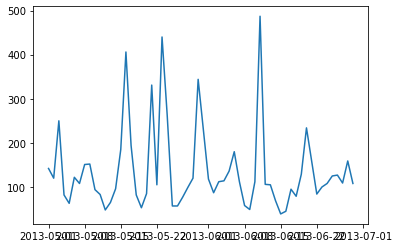

In [11]:
plt.plot(df.date, df.num_tweets)